
# Business Data Analytics Challenge:
# Prediction of Electricity Flows

  

Fabio Costa  
Laurin Eichberger  
Nevena Nikolajevic  
Ömer Özumerzifon  
Lukas Petry  
Hendrik Scherner  


In [ ]:
# Disable all warnings in this notebook to improve readability. 
import warnings
warnings.simplefilter("ignore")

## 1 Domain Understanding

### Predict the cross-border power flow between Germany and its neighbors

#### European integration of electricity market is triggering…  

* Need to predict the physical net current flow of Germany to the neighboring countries  
* Adequate reactions facilitated by reliable predictions   


Goal of this project is to develop a ML-based model that can reliably perform the predictions based on publicly available data input.  
 

### Predict the cross-border power flow between Germany and its neighbors  

#### Output requirements of the model:   
* Time stamp with hourly granularity   
* Net electricity flow per country  


The model is not trained again before the input of future data and shall therefore be generalizable.  


Quality indicator of the prediction is quantity-weighted RSME.  

### Possible Influences 
First step was a brainstorming about the possible influence factors without specifying potential data sources and required formats. Afterwards we clustered the factors into a mind-map.   

The main factor categories we identified are:  
* Market-related data
* Physical restrictions  
* Production and Weather data  

Besides data related to Germany, the influence factors can always be extended to neighboring countries, this means that most of the identified factors exist for every other country and could thus be used as further input for training our model.   

However, our main independent variables are related to Germany, improved by weather data from neighboring countries.   


### Possible Influences

<img src="img/MindMap2.png"> 

In [14]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

### Data sources

Only publicly availabe data: 

<br>


|Extracted Data | Source |
|:-------------:|:------:|
| Net Electricity Flow | SMARD, xyz |
| Production forecast | SMARD, xyz |
| Consumption forecast | SMARD, xyz |
| Realized Prodcution | SMARD, xyz |
| Realized consumption | SMARD, xyz |
| Price Data | SMARD, xyz |
| Weather | DWD, DMI, <br>   LFBD, LKPR |

<br>

* SMARD, DWD and DMI data was availale for June 2015 - June 2019  
* Rest?

* We built a scraper for the German and Danish weather data (DWD, DMI)

<br>
<br>

Abbreviations:
```
DWD (German Meteorological Institute)  
DMI (Danish Meteorological Institute)  
LFBD (Airport Bordeaux)  
LKPR (Airport Prague)  
```

----

# 2. Data Gathering

## General Concept 
<br>

<img src="img/Struktur.png">

<br>

---

## 3. Data Analysis & Preprocessing
* Historic data of the output variable is av-ailable --> plot to get first impression  
* Korrelationsplots von Hendrik  
* Prophet Decomposition   

## 1. General Analysis

In [1]:
from bda_bokeh import bda_bokeh
df = bda_bokeh.import_data()
df = bda_bokeh.preprocessing(df)
bda_bokeh.show_bokeh(df)

Import File: DE_Physikalischer Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer Stromfluss_201706020000_201906022359_1.csv 


Loading BokehJS ...

---

## 2. Time Series Analysis

In [2]:
export_columns = [col for col in df.columns if col[-2::]=='EX' ]
import_columns = [col for col in df.columns if col[-2::]=='IM' ]

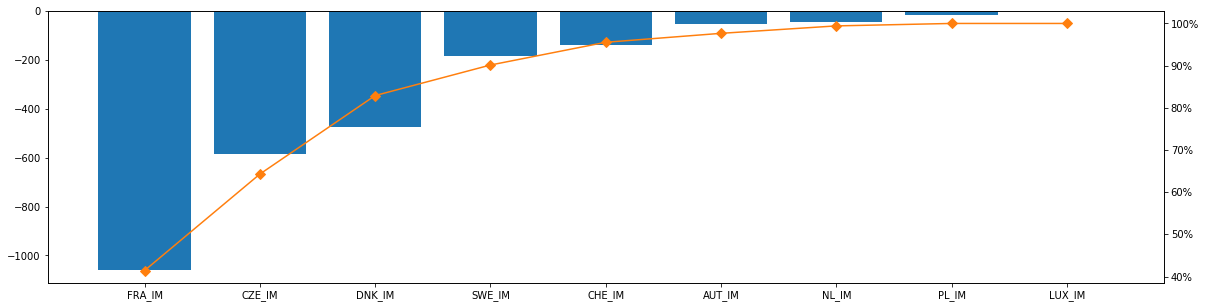

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd

import_data = pd.DataFrame(df[import_columns].mean().sort_values(ascending=True),columns=["mean_import"])
import_data['cum_percentage'] = (import_data.cumsum()/import_data.sum())*100

fig, ax = plt.subplots(figsize=[20,5])
ax.bar(import_data.index,import_data.mean_import)
    
ax2 = ax.twinx()
ax2.plot(import_data.index,import_data.cum_percentage, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

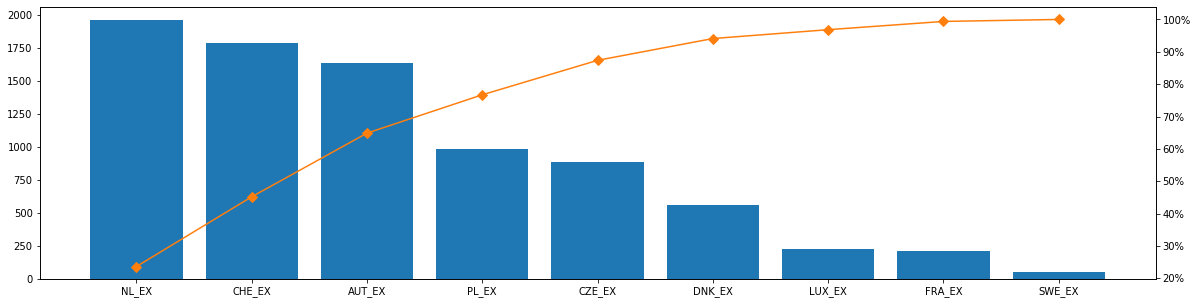

In [5]:
export_data = pd.DataFrame(df[export_columns].mean().sort_values(ascending=False),columns=["mean_import"])
export_data['cum_percentage'] = (export_data.cumsum()/export_data.sum())*100

fig, ax = plt.subplots(figsize=[20,5])
ax.bar(export_data.index,export_data.mean_import)
    
ax2 = ax.twinx()
ax2.plot(export_data.index,export_data.cum_percentage, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

---

## 3. Korrelation

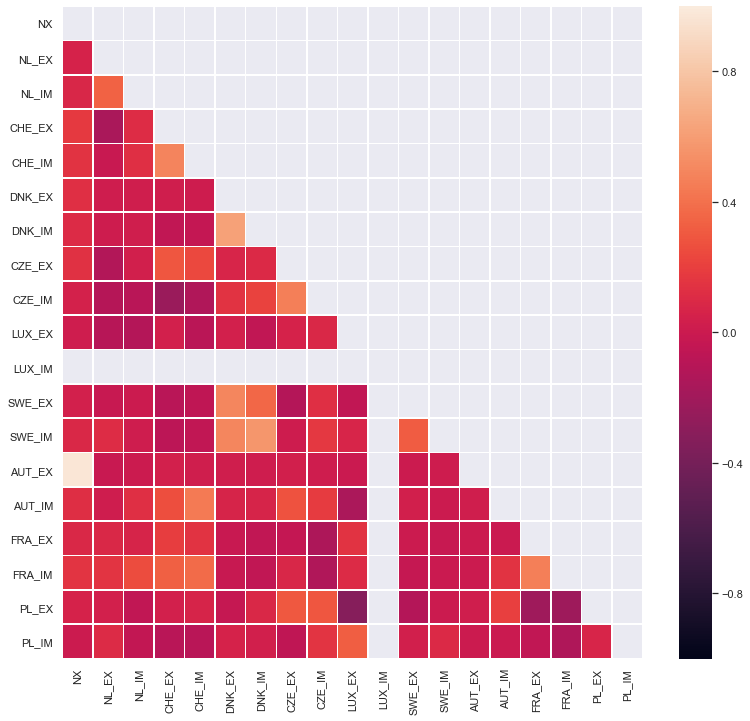

In [6]:
import numpy as np
import seaborn as sns
sns.set()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(13, 12)
mask = np.zeros_like(df.loc[:,'NX':'PL_IM'].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(df.loc[:,'NX':'PL_IM'].corr(),mask=mask,vmin=-1,vmax=1,linewidths=.5)

<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
    Major Findings
    * #### seasonality of the net export
* #### maximum capacities of countries
* #### downward trend
</p>

---

# 4. Model

## 4.1. Possible Models

### Auto-Regressiv Models:
- OLS
- ARIMA
- FBProphet

### Deep Nets
- RNN / LSTM 
- CNN 
- CNN + LSTM 

## 4.2. Autro-Regressiv Model: FBProphet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


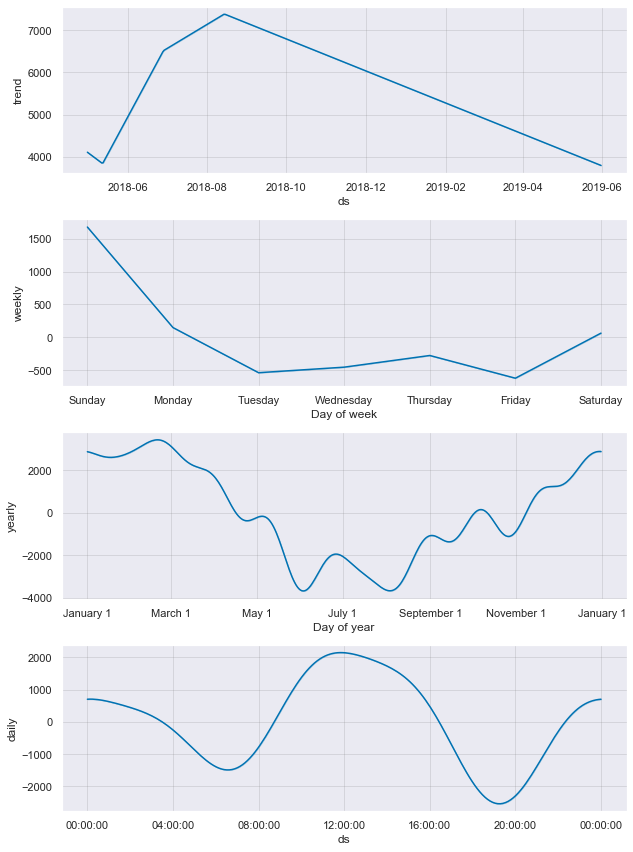

In [7]:
from model.prophet import bda_prophet
from fbprophet import Prophet
import pandas as pd
from datetime import datetime


country_codes = bda_prophet.extract_country_codes(df)
df = bda_prophet.get_net_export(df, country_codes, ["EX","IM"])

df_NX = df[['Date', 'NX']]
df_NX = bda_prophet.rename_columns_for_prophet(df_NX)

m = Prophet()
m.fit(df_NX)

future = pd.DataFrame({"ds": pd.date_range(start=datetime(2018,5,1), end=datetime(2019,5,31,23,0,0))})
forecast = m.predict(future) 
fig2 = m.plot_components(forecast)

A decomposition of linear components with Facebook's Prophet creates additional insights. 

----

## 4.3 Deep Nets

In [12]:
from keras.models import load_model
import model.cnn_lstm.evaluation as evaluation
model = load_model('model/cnn_lstm/cnn_lstm.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 48, 85)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 48, 85)        96        
_________________________________________________________________
activation_2 (Activation)    (None, 32, 48, 85)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 48, 85)         33        
_________________________________________________________________
lambda_3 (Lambda)            (None, 48, 85)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 100)           74400     
_________________________________________________________________
lambda_4 (Lambda)            (None, 24, 100)           0         
__________

---

## 4.4 Model Evaluation and Forecast for May

Tabelle

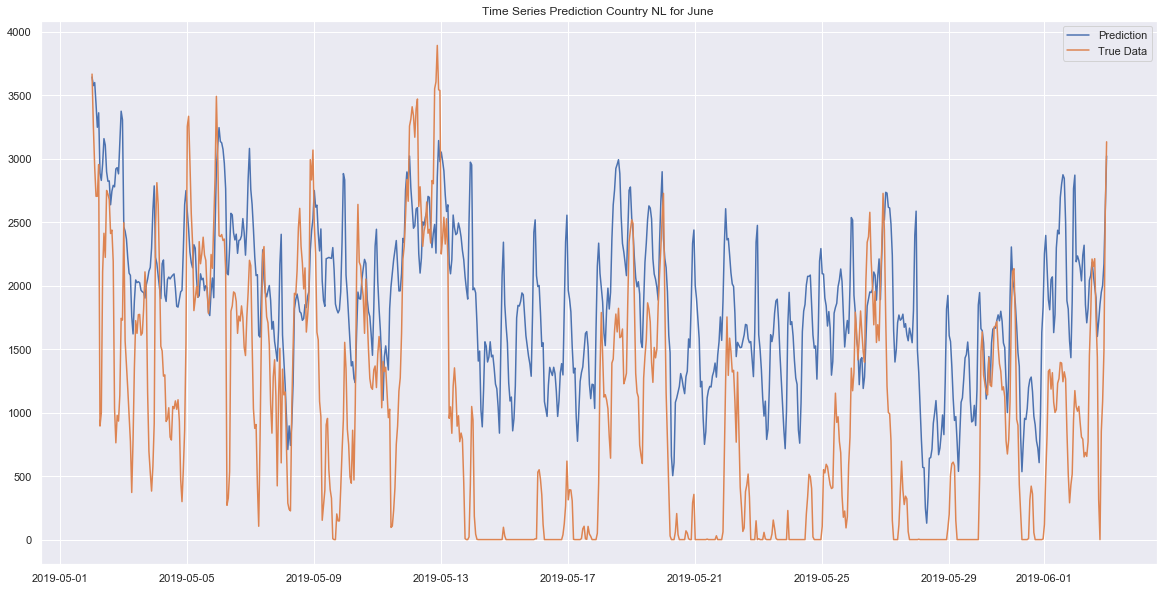

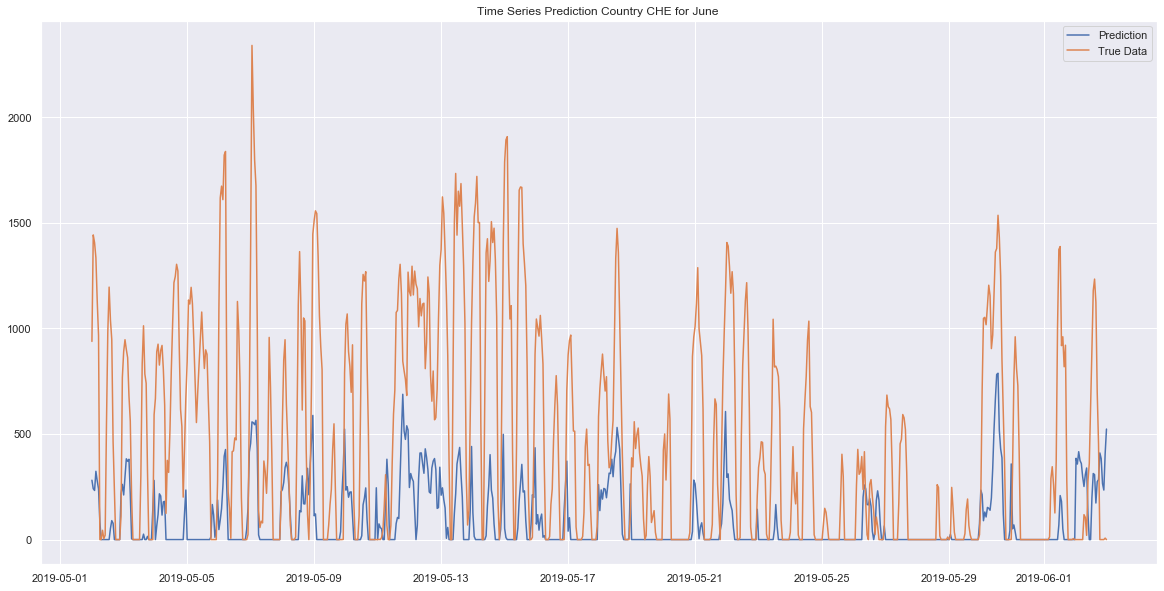

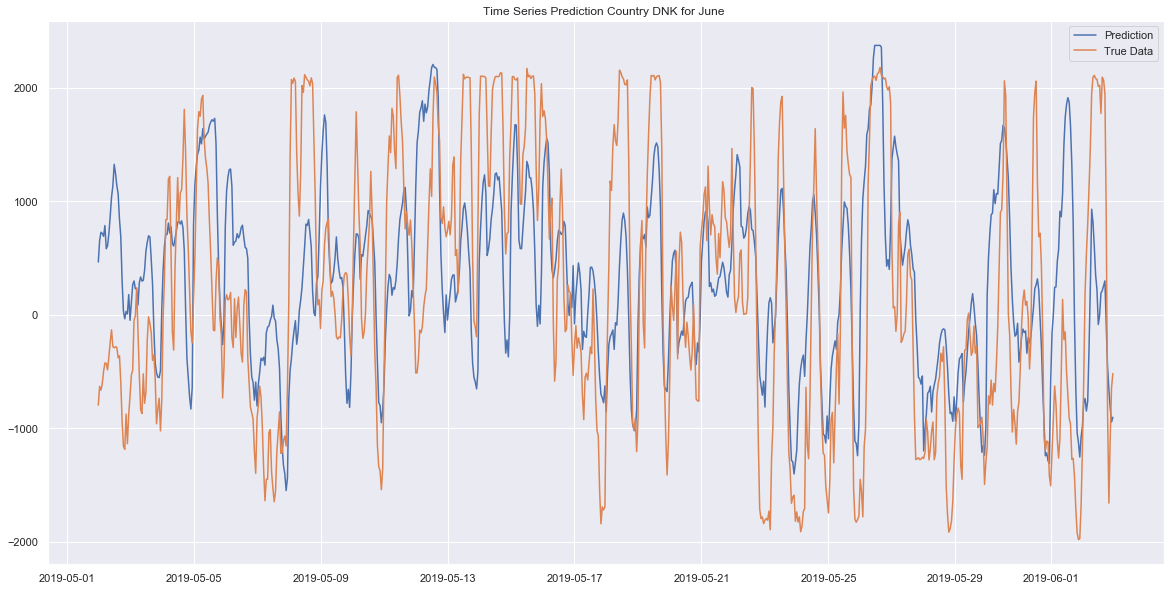

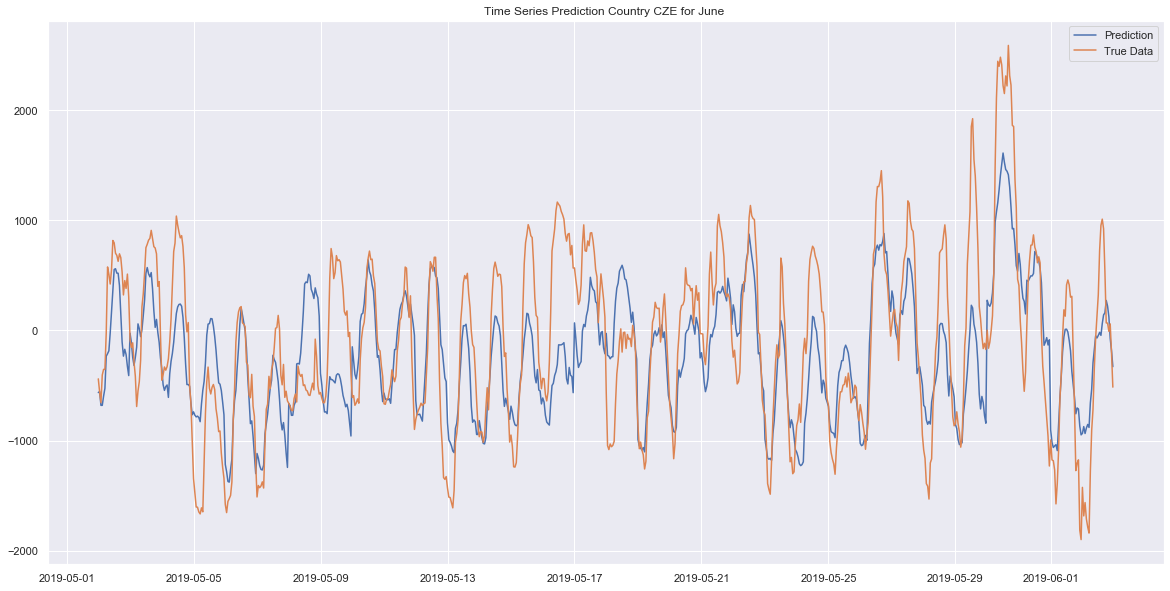

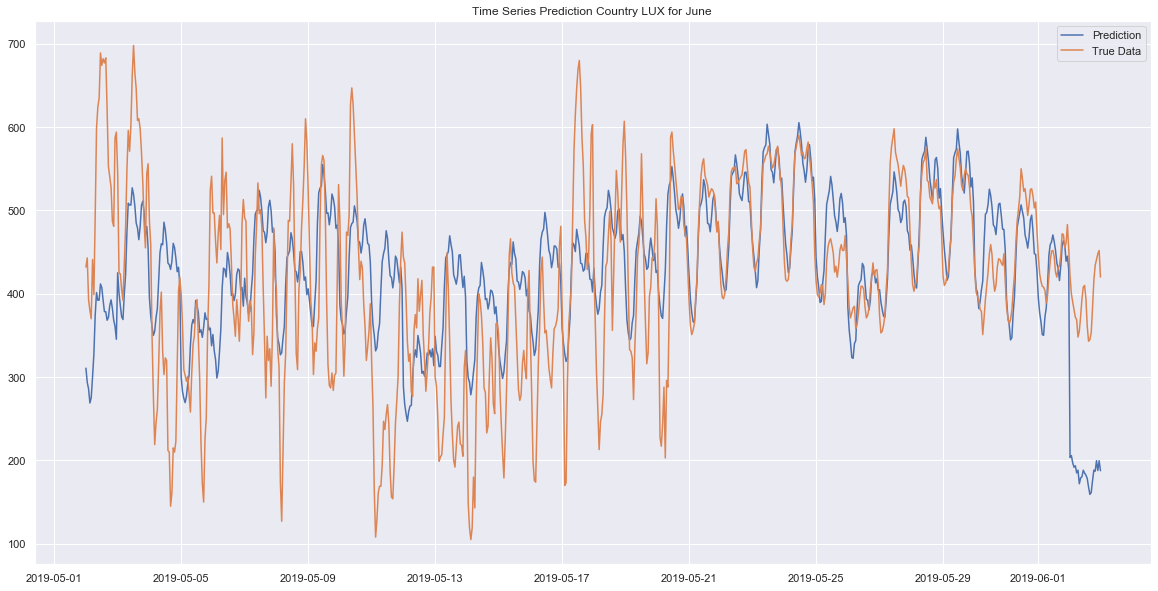

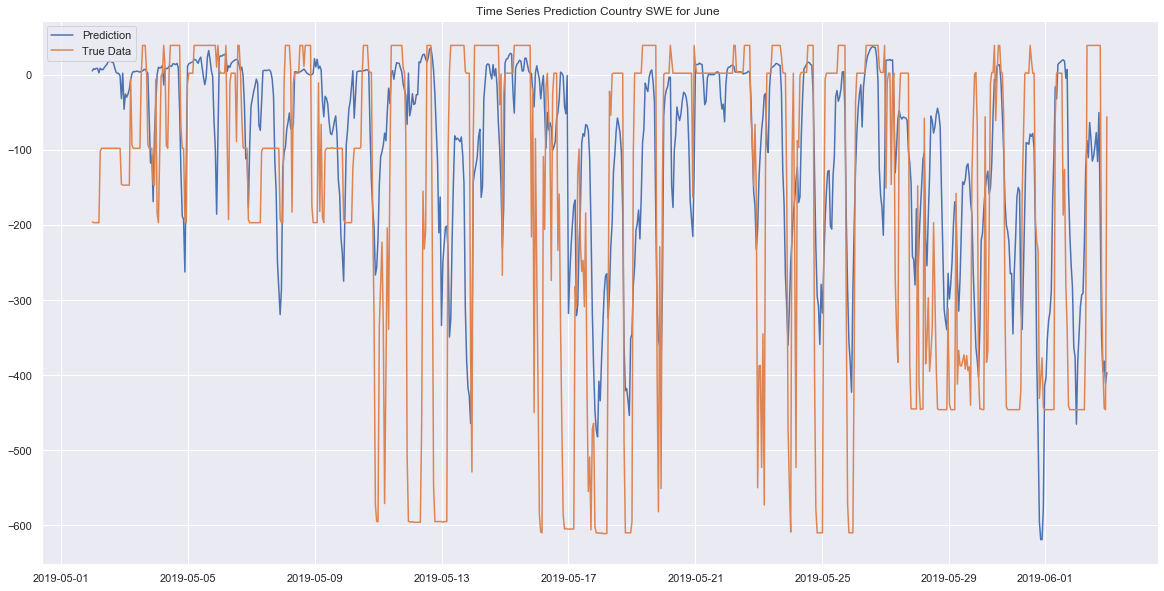

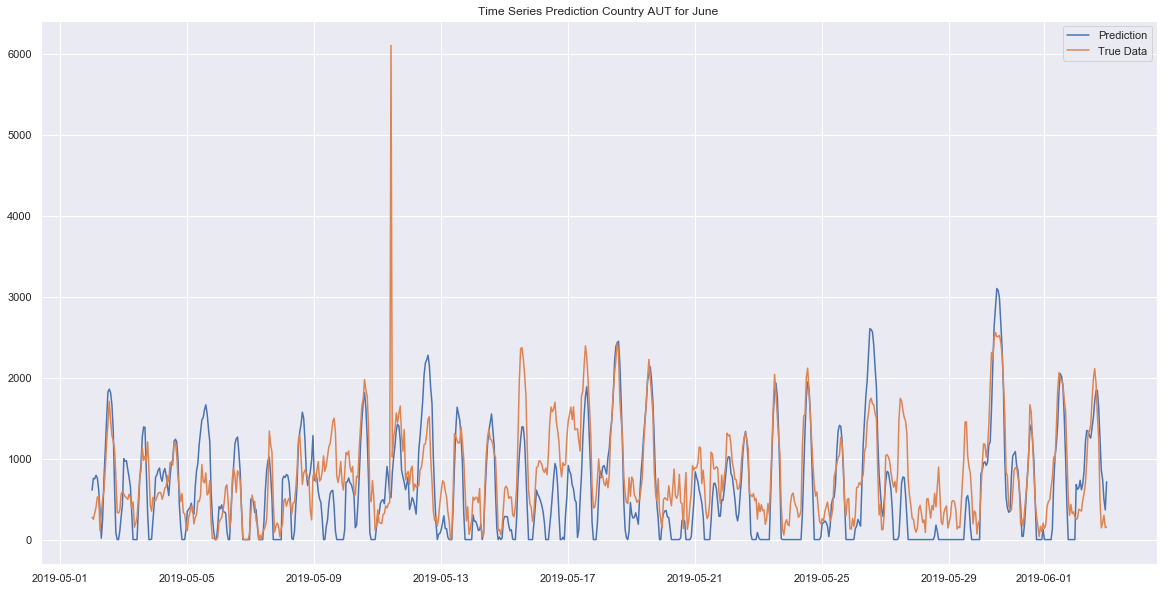

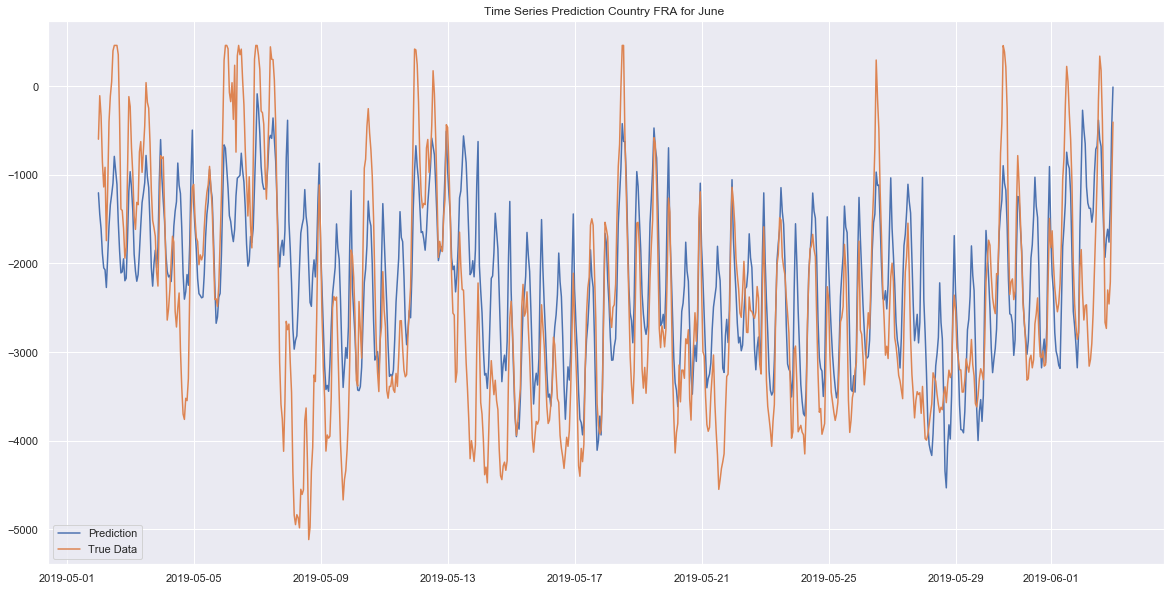

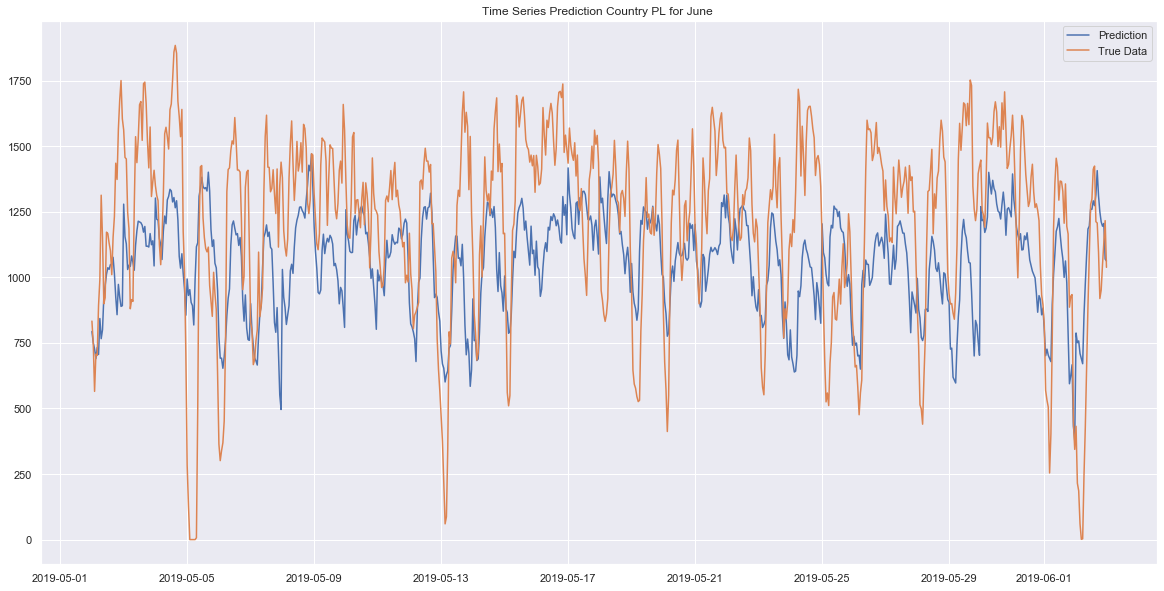

MAE:
NL     988.170881
CHE    421.296871
DNK    781.078842
CZE    413.635996
LUX     74.647817
SWE    131.848726
AUT    359.172287
FRA    716.377216
PL     277.680249
dtype: float64

Gesamt:462.656542789171


In [13]:
df_predictions = pd.read_csv('model/cnn_lstm/df_predictions.csv',sep=";",index_col=0,parse_dates=['Tag'])
df_true_eval_values = pd.read_csv('model/cnn_lstm/df_true_test_values.csv',sep=";",index_col=0,parse_dates=['Tag'])

cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
evaluation.plot_and_calculate_error(df_predictions,df_true_eval_values,cols) 

<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
    Major Findings
    * #### seasonality of the net export
* #### maximum capacities of countries
* #### downward trend
</p>

---

## 5. Conclusion 
Was haben wir gelernt, wo ist Verbesserungpotential. 


---

----

By: Lukas Petry, Ömer Özumerzifon, Laruin Eichberger, Fabio Costa, Nevena Nikolajevic, Hendrik Scherner